In [34]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from cltl.dialogue_evaluation.metrics.brain_measures import *
from cltl.dialogue_evaluation.metrics.graph_measures import *
from rdflib import ConjunctiveGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
from sklearn.preprocessing import MinMaxScaler, StandardScaler

% matplotlib inline

UsageError: Line magic function `%` not found.


In [4]:
ABSOLUTE_PATH = '.'
DATA_FOLDER = ABSOLUTE_PATH + f'/../resources/'

RDF_FOLDERS = [
    Path(f'../resources/Ratio-conflicts-to-statements_2_lea/2022-03-07-14-25/').resolve(),
    Path(f'../resources/Ratio-conflicts-to-triples_2_thomas/2022-03-07-14-25/').resolve(),
    Path(f'../resources/Ratio-perspectives-to-statements_2_piek/2022-03-07-15-17/').resolve(),
    Path(f'../resources/Total-triples_2_tae/2022-03-07-17-20/').resolve()
]

CONVO_IDS = ['Ratio-conflicts-to-statements', 'Ratio-conflicts-to-triples',
             'Ratio-perspectives-to-statements', 'Total-triples']

THOUGHT_TYPES = ['complement_conflict', 'negation_conflict',
                 'subject_gap', 'object_gap',
                 'no_statement_novelty', 'statement_novelty', 'entity_novelty', 'overlap']

METRICS = ['Average degree', 'Shortest path', 'Sparseness',
           'Average degree centrality', 'Number of strong components']


## Accumulated episodic memories


### Create brains

In [23]:
brains_as_graph = []
brains_as_netx = []

# TODO: this is just the final graph of the final conversation, not the actual final one
for rdf_folder in RDF_FOLDERS:
    files = sorted([path for path in rdf_folder.glob('*.trig')])
    if files:
        print(f"\nCreate new brain: {files[-1]}")
        brain_as_graph = ConjunctiveGraph()

        print(f"\tAdding triples to brain")
        brain_as_graph.parse(files[-1], format='trig')
        brain_as_netx = rdflib_to_networkx_multidigraph(brain_as_graph)

        brains_as_graph.append(brain_as_graph)
        brains_as_netx.append(brain_as_netx)

print(f"\nFound {len(brains_as_graph)} final graphs")


Create new brain: /Users/sbaez/Documents/PhD/research/thought-selection/resources/Ratio-conflicts-to-statements_2_lea/2022-03-07-14-25/brain_log_2022-03-07-15-00-56.trig
	Adding triples to brain

Create new brain: /Users/sbaez/Documents/PhD/research/thought-selection/resources/Ratio-conflicts-to-triples_2_thomas/2022-03-07-14-25/brain_log_2022-03-07-15-03-21.trig
	Adding triples to brain

Create new brain: /Users/sbaez/Documents/PhD/research/thought-selection/resources/Ratio-perspectives-to-statements_2_piek/2022-03-07-15-17/brain_log_2022-03-07-15-47-24.trig
	Adding triples to brain

Create new brain: /Users/sbaez/Documents/PhD/research/thought-selection/resources/Total-triples_2_tae/2022-03-07-17-20/brain_log_2022-03-07-17-38-45.trig
	Adding triples to brain

Found 4 final graphs


### Score brains

In [25]:
graphs_scores = []
for brain_as_graph, brain_as_netx in zip(brains_as_graph, brains_as_netx):
    print(f"\nEvaluating brain")

    print(f"\tCrude statistics")
    turns = get_number_utterances(brain_as_graph)
    print(f"\t\tTurns: {turns}")
    claims = get_number_statements(brain_as_graph)
    print(f"\t\tClaims: {claims}")
    perspectives = get_number_perspectives(brain_as_graph)
    print(f"\t\tPerspectives: {perspectives}")

    print(f"\tGraph metrics")
    ad = get_avg_degree(brain_as_netx)
    print(f"\t\t{METRICS[0]}: {ad}")
    sp = get_shortest_path(brain_as_netx)
    print(f"\t\t{METRICS[1]}: {sp}")
    s = get_sparseness(brain_as_netx)
    print(f"\t\t{METRICS[2]}: {s}")
    nc = get_avg_degree_centr(brain_as_netx)
    print(f"\t\t{METRICS[3]}: {nc}")
    comp = get_number_strong_comp(brain_as_netx)
    print(f"\t\t{METRICS[4]}: {comp}")

    scores = [ad, nc, sp, comp, s]
    graphs_scores.append(scores)

graphs_scores = np.array(graphs_scores)


Evaluating brain
	Crude statistics
		Turns: 30
		Claims: 30
		Perspectives: 28
	Graph metrics
		Average degree: 5.0182555780933065
		Shortest path: 3.9874833028249146
		Sparseness: 0.005089508699891792
		Average degree centrality: 0.010199706459539243
		Number of strong components: 349

Evaluating brain
	Crude statistics
		Turns: 25
		Claims: 21
		Perspectives: 21
	Graph metrics
		Average degree: 5.500308451573103
		Shortest path: 2.760341979025025
		Sparseness: 0.0008472428311173406
		Average degree centrality: 0.0016971022683039503
		Number of strong components: 3076

Evaluating brain
	Crude statistics
		Turns: 33
		Claims: 32
		Perspectives: 31
	Graph metrics
		Average degree: 5.2103174603174605
		Shortest path: 3.900020511849538
		Sparseness: 0.0051492819349962205
		Average degree centrality: 0.010358484016535708
		Number of strong components: 360

Evaluating brain
	Crude statistics
		Turns: 26
		Claims: 26
		Perspectives: 25
	Graph metrics
		Average degree: 5.044496487119438
		Sh

### Star Plot

In [ ]:
def plot_spider_scores(graphs_scores, graph_ids):
    scaler = MinMaxScaler()
    scaled_graph_scores = scaler.fit_transform(graphs_scores)

    fig = go.Figure()

    for scores, id in zip(scaled_graph_scores, graph_ids):
        fig.add_trace(go.Scatterpolar(r=scores,
                                      theta=METRICS,
                                      fill='toself',
                                      name=f'{id}'))

    fig.update_layout(polar=dict(radialaxis=dict(visible=True), ), showlegend=True)

    fig.show()
    fig.write_image(Path(DATA_FOLDER).resolve() / f'aggregation' / f'final_graph_starplot.png')


In [ ]:
plot_spider_scores(graphs_scores, CONVO_IDS)

## Utility estimates

### Read policies

In [5]:
types_dfs, content_dfs = [], []
for rdf_folder, id in zip(RDF_FOLDERS, CONVO_IDS):
    thoughts_file = rdf_folder.parent / "thoughts.json"
    with open(thoughts_file, "r") as file:
        data = json.load(file)

    df = pd.DataFrame(data["data"])

    # Filter columns
    missing_columns = [col for col in THOUGHT_TYPES if col not in df.columns]
    for col in missing_columns:
        df[col] = 0
    types_df = df[THOUGHT_TYPES]
    content_df = df.drop(THOUGHT_TYPES, axis=1)

    # Merge statement novelties
    types_df['statement_novelty'] = types_df['statement_novelty'] + types_df['no_statement_novelty']
    types_df.drop('no_statement_novelty', axis=1, inplace=True)

    types_dfs.append(types_df)
    content_dfs.append(content_df)

/var/folders/3s/tm5t90ds597b_2n9wm2v1pn00000gn/T/ipykernel_15926/438078368.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  types_df['statement_novelty'] = types_df['statement_novelty'] + types_df['no_statement_novelty']
/Users/sbaez/opt/miniconda3/envs/thought-selection/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Pie plot

In [18]:
def plot_pie_counts(dfs):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    labels = THOUGHT_TYPES
    labels.remove('no_statement_novelty')

    for idx, df in enumerate(dfs):
        def fmt(x):
            total = df.loc['count'].sum()
            return '{:.1f}% ({:.0f})'.format(x, total * x / 100)

        # Plot
        ax = axes[idx // 2, idx % 2]
        fig.add_subplot(ax)
        plt.pie(df.loc['count'], autopct=fmt, textprops={'fontsize': 9})

        # Format plot
        ax.set_title(id)
        fig.subplots_adjust(wspace=.01, hspace=.01)
        plt.axis('off')

    fig.legend(labels, loc="center left")

    # fig.show()
    fig.savefig(Path(DATA_FOLDER).resolve() / f'aggregation' / f'thought_types_piechart.png', dpi=300,
                transparent=False,
                bbox_inches='tight')
    # plt.close()


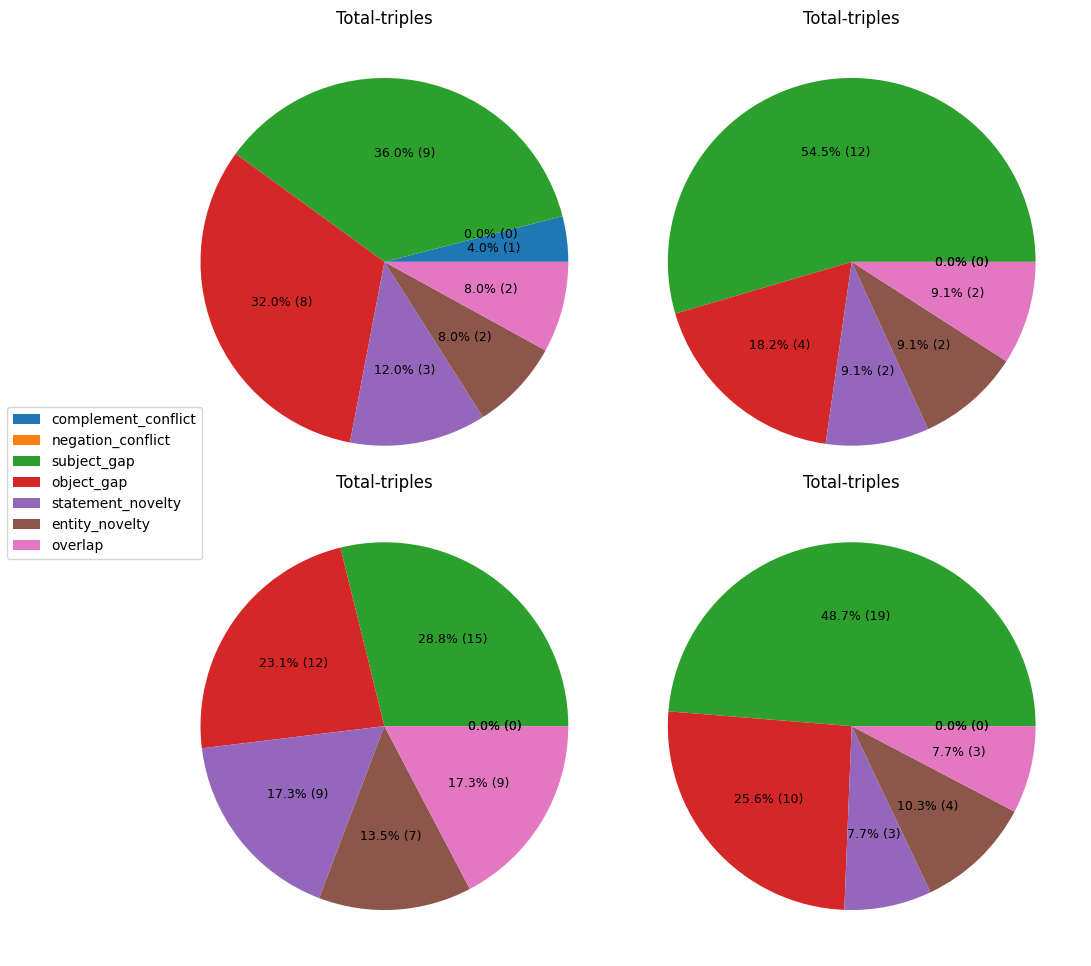

In [19]:
plot_pie_counts(types_dfs)

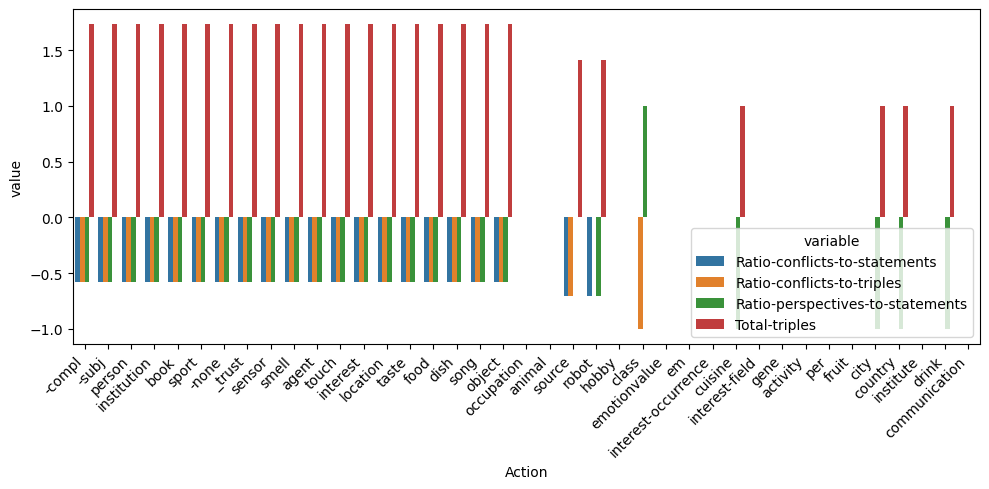

In [40]:

# Massage data
agg_df = pd.DataFrame()
for id, content_df in zip(CONVO_IDS, content_dfs):
    if len(agg_df) == 0:
        agg_df[id] = content_df.loc['value']
    else:
        agg_df = pd.concat([agg_df, content_df.loc['value']], axis=1)
        agg_df.rename(columns={'value': id}, inplace=True)

scaler = StandardScaler()
scaled = pd.DataFrame(scaler.fit_transform(agg_df.T).T, columns=agg_df.columns)
scaled['Action'] = agg_df.index
df1 = pd.melt(scaled, id_vars=['Action'])

# Plot
fig = plt.figure(figsize=(10, 5), tight_layout=True)
plt.ylabel("$Value$ $(Q)$")
plt.xlabel("$Actions$ $(a)$")
plt.xticks(rotation=45, ha="right")
# fig.legend(loc="center left")

sns.barplot(x='Action', y='value', hue='variable', data=df1)
fig.savefig(Path(DATA_FOLDER).resolve() / f'aggregation' / f'thought_content_barchart.png', dpi=300,
            transparent=False,
            bbox_inches='tight')
